# Домашняя работа. Деревья решений.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](99-extra__ml-course-msu-Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'./data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [35]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import erfc
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

In [16]:
df = pd.read_csv('winequality-red.csv',sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


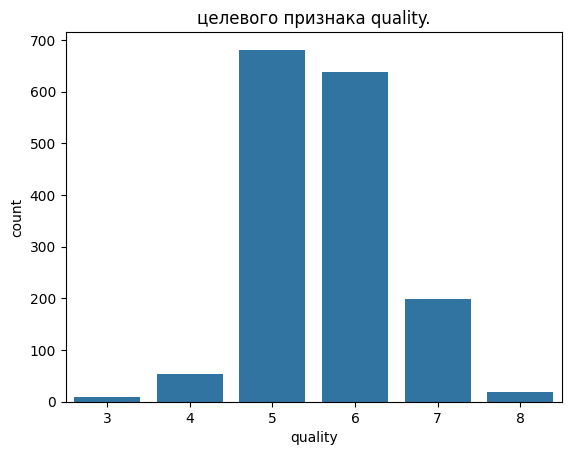

In [12]:
sns.countplot(x='quality', data=df)
plt.title('целевого признака quality.')
plt.show()


In [ ]:
Странный датасет вроде должен быть от 0 до 10 а по факту от 3 до 8

In [14]:
X = df.drop(columns=['quality'])
y = df['quality']

In [17]:
class_counts = y.value_counts()
print("Количества представителей каждого класса:\n", class_counts)

Количества представителей каждого класса:
 quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [ ]:
Еще и перекос очень большой

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов.

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [19]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
models = {
    "KNeighbors (без масштабирования)": KNeighborsClassifier(n_neighbors=10),
    "KNeighbors (с масштабированием)": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10)),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "Bagging (100 деревьев)": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42),
    "Bagging (половина признаков)": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, max_features=0.5, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Оценка моделей
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: средняя accuracy = {scores.mean():.4f}")

KNeighbors (без масштабирования): средняя accuracy = 0.5122
KNeighbors (с масштабированием): средняя accuracy = 0.5816
RidgeClassifier: средняя accuracy = 0.5835
DecisionTree: средняя accuracy = 0.6179
Bagging (100 деревьев): средняя accuracy = 0.6980
Bagging (половина признаков): средняя accuracy = 0.6948
RandomForest: средняя accuracy = 0.7017


In [31]:
Удивительно что можно сделать это так

SyntaxError: invalid syntax (<ipython-input-31-54458dd2a8a3>, line 1)

### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

1) Так сам алгоритм работает(выбор ближайших) без масштабирования очевидно что качество падает

2) Деревья решений работают по правилам разбиений, которые инвариантны к масштабу признаков(признаки сравниваются между собой)

3)По факту вышло не так, но по идее это увеличивает разнообразие деревьев

4)RidgeClassifier Вероятно это связано с тем какие у нас данные в датасете они очень странные. Судя по следующем пункту это должен был быть RandomForest из-за чувствительность к параметрам, но по факту это не так


## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [41]:
digits = load_digits()

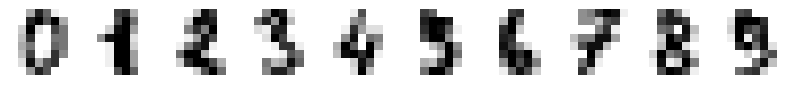

In [56]:
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gist_yerg')
    ax.axis('off')
plt.show()

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [65]:
N = digits.data.shape[1]
sqrt_N = int(np.sqrt(N))
models = {
    "Decision Tree (default)": DecisionTreeClassifier(),
    "Bagging (100 trees)": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100),
    "Bagging (100 trees, max_features=sqrt(N))": BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                                   n_estimators=100, max_features=sqrt_N),
    "Bagging (100 trees, max_features split=sqrt(N))": BaggingClassifier(estimator=DecisionTreeClassifier(max_features=sqrt_N),
                                                                         n_estimators=100),
    "Random Forest (100 trees)": RandomForestClassifier(n_estimators=100)
}
results = {}
for name, model in models.items():
    scores = cross_val_score(model, digits.data, digits.target, cv=10, scoring='accuracy')
    results[name] = scores.mean()

for name, score in results.items():
    print(f"{name}: {score:.4f}")

Decision Tree (default): 0.8236
Bagging (100 trees): 0.9248
Bagging (100 trees, max_features=sqrt(N)): 0.9249
Bagging (100 trees, max_features split=sqrt(N)): 0.9477
Random Forest (100 trees): 0.9493


### 2.3 В чём разница? (3 балла)

Ответье на вопрос:

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

В первом случаем мы меняет по сути деревья(разнообразие деревьев), а во втором ансамбли(подмножество для обучения)


### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [67]:
tree_counts = [1, 5, 10, 15, 50, 100, 150, 200, 300]
scores = []
for count in tree_counts:
    clf = RandomForestClassifier(n_estimators=count)
    scores.append(cross_val_score(clf, digits.data, digits.target, cv=10).mean())

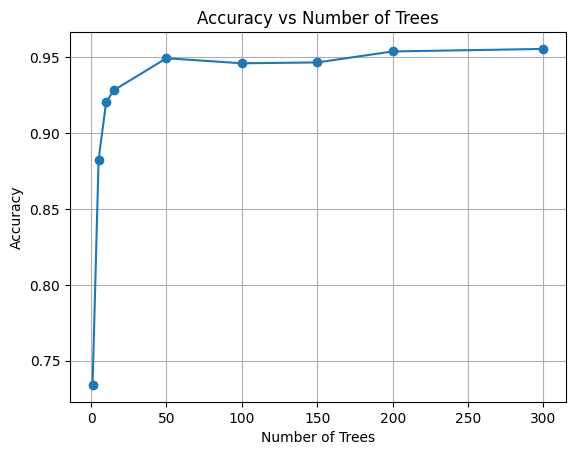

In [68]:
plt.plot(tree_counts, scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees")
plt.grid()
plt.show()

In [71]:
best_count = tree_counts[np.argmax(scores)]
print(f"самое хорошее качество {best_count} деревьях.")

самое хорошее качество 300 деревьях.


### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

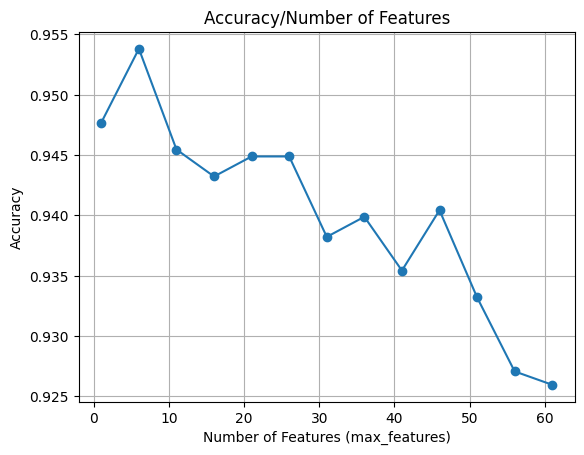

In [73]:
feature_counts = range(1, 65, 5)
scores = []
for count in feature_counts:
    clf = RandomForestClassifier(n_estimators=100, max_features=count)
    scores.append(cross_val_score(clf, digits.data, digits.target, cv=10).mean())

plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features (max_features)")
plt.ylabel("Accuracy")
plt.title("Accuracy/Number of Features")
plt.grid()
plt.show()

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)

1)Качество стабилизируется но сложность вычислений растет так что это бессмыслено в большинстве случаев

2)Слишком маленькие уменьшают качество слишком большие разнообразие. Тоесть при малых значениях у дерева слишком малое кол-во данных и при больших они ведут себя как обычные деревья

3)Так работает случайный лес. Когда max_features мало, деревья больше отличаются друг от друга. А если оно большое то деревья почти одинаковые

4)Так все то же самое большое значение плохо тем что у нас дерево подгоняется даже под выборсы и неустойчив к новым данным. А малые деревья просто могут быть недобучены